### Exploratory Data Analysis & Feature Engineering

Objective:
    1. To get an insight into input dataframe.
    2. To get an understanding of basic statistics.
    3. Identify features of importance through VIF, PCA and / or Decision Trees

How to use this notebook?
    1. Maintain all the input datasets (*.csv) in a folder.
    2. Select the input dataset you want to analyze by specifying the appropriate index when prompted.
    3. Speficy the PREFIX: All output files are prefixed with this prefix. Ex. Output_ 
    3. Specify the number of features and targets. (Targets can also be zero - unsupervized learning)
    4. Tabular output are generated and saved as *.xlsx. Figures are in *.png format.

Assumptions:
    1. Only *.csv files are currently being read.
    2. Target columns are placed after the features in the *.csv
    3. Median imputing is performed where needed. Change it appropriately as needed.

Additional Libraries Needed:
    1. conda install -c conda-forge jupyter_contrib_nbextensions.
    2. conda install -c conda-forge tabulate
    3. conda install -c conda-forge pandas-profiling
    4. conda install -c conda-forge ppscore
    5. conda install -c conda-forge hiplot
    6. pip install pca


In [1]:
# Import relevant libraries

import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.options.display.width=None

import ppscore as pps

from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from pca import pca
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA as SKLPCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Global constants

RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.2  # test_size where used is assigned TESTSIZE

In [3]:
# Dataset I/O definitions

PATH = r"C:\DSML_Case_Studies_2021.04.24\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies_2021.04.24\03_Output"


In [4]:
# Pick the dataset to be analyzed & specify a prefix for output files and figures

for r, d, f in os.walk(PATH):
    for file in f:
        if file.endswith(".csv"):
            continue
    print(f)
nfiles = len(f)

userinp = int(input("Enter input file index:"))
while userinp > (nfiles-1):
    print(f)
    userinp = int(input("Enter input file index:"))
    continue

files = f[userinp]

FNAME = f"{PATH}\{files}"
PREFIX = input("Prefix for Output Files & Figures: ")
PREFIX = f"\{PREFIX}"

# Specify number of features and targets in the dataset

n_features = int(input("Enter the Number of Features in Dataset: "))
n_target = int(input("Enter the Number of Targets in Dataset: "))

['Dataset_Creditcard_Mod_17x0.csv', 'Dataset_Indian_Liver_Patient_10x1.csv', 'Dataset_Insurance_6x1.csv', 'Dataset_Lower_Back_Pain_12x1.csv', 'Dataset_Petrol_Consumption_4x1.csv']
Enter input file index:2
Prefix for Output Files & Figures: Insurance_
Enter the Number of Features in Dataset: 6
Enter the Number of Targets in Dataset: 1


In [5]:
# Dataset Definition

df = pd.read_csv(f"{FNAME}")
df = df.round(decimals=4)
maxcol = len(df.columns)

DF_INFO = df.dtypes.to_frame('Data Type').reset_index()

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

pd.set_option('display.max_columns', len(collst))

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]


In [6]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue


In [7]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

print(df.isnull().sum(), end='\n\n')
df = df.apply(lambda x: x.fillna(x.mean()), axis=0)
print(df.isnull().sum(), end='\n\n')


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64



In [8]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['age', 'sex', 'bmi', 'children', 'smoker', 'region']

List of Targets: ['expenses']

List of Categorical Variables: ['sex', 'smoker', 'region']

List of Categorical Targets []



In [9]:
# Sanity checks before proceeding further

df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,3,16884.92
1,18,1,33.8,1,0,2,1725.55
2,28,1,33.0,3,0,2,4449.46
3,33,1,22.7,0,0,1,21984.47
4,32,1,28.9,0,0,1,3866.86


In [10]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github"))

|          |   count |      mean |       std |     min |     25% |     50% |     75% |     max |
|----------|---------|-----------|-----------|---------|---------|---------|---------|---------|
| age      |    1338 |    39.207 |    14.05  |   18    |   27    |   39    |    51   |    64   |
| sex      |    1338 |     0.505 |     0.5   |    0    |    0    |    1    |     1   |     1   |
| bmi      |    1338 |    30.665 |     6.098 |   16    |   26.3  |   30.4  |    34.7 |    53.1 |
| children |    1338 |     1.095 |     1.205 |    0    |    0    |    1    |     2   |     5   |
| smoker   |    1338 |     0.205 |     0.404 |    0    |    0    |    0    |     0   |     1   |
| region   |    1338 |     1.516 |     1.105 |    0    |    1    |    2    |     2   |     3   |
| expenses |    1338 | 13270.4   | 12110     | 1121.87 | 4740.29 | 9382.03 | 16639.9 | 63770.4 |


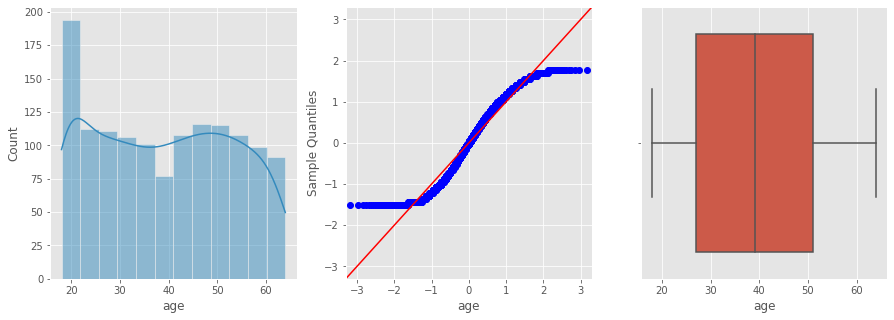

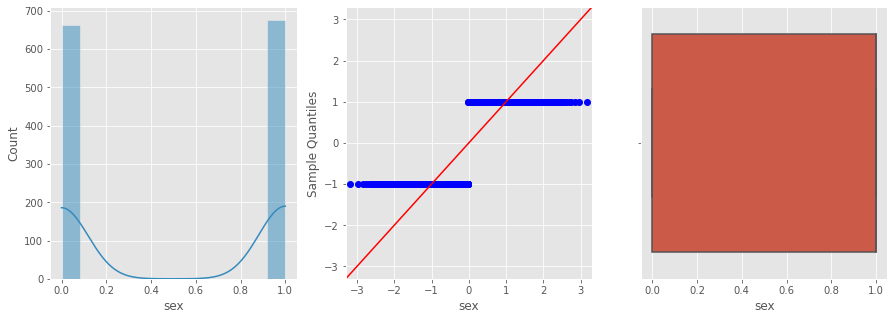

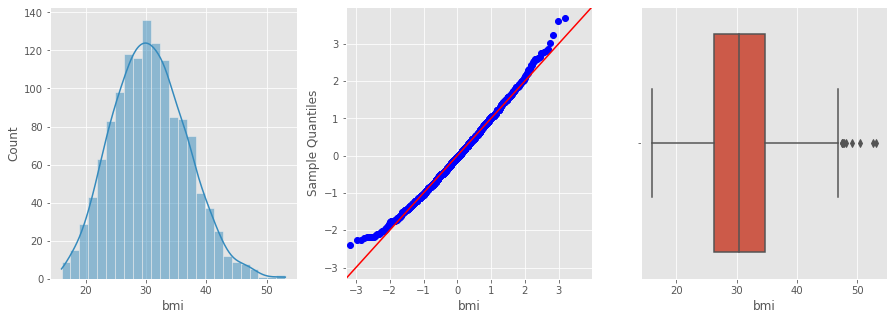

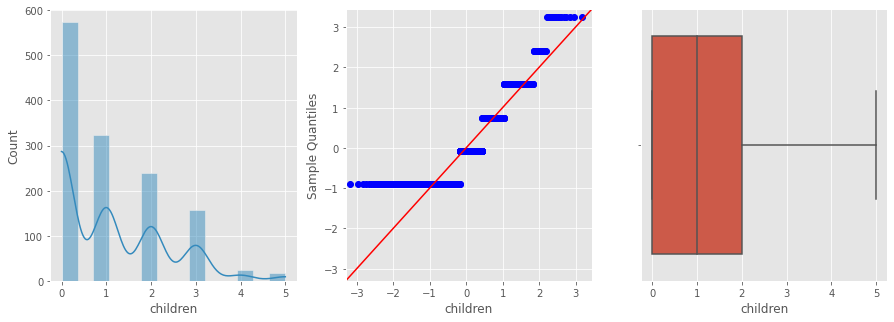

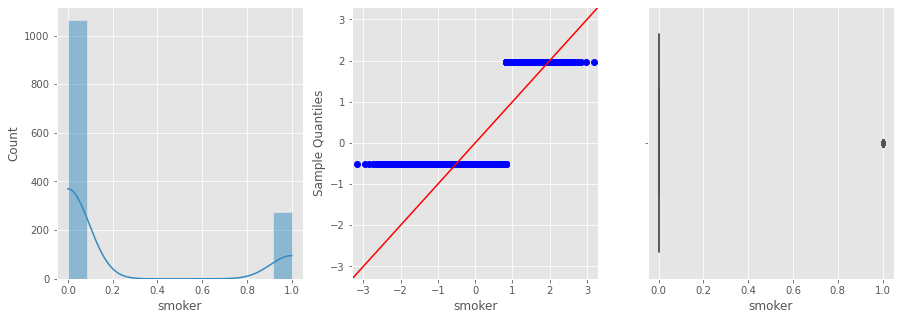

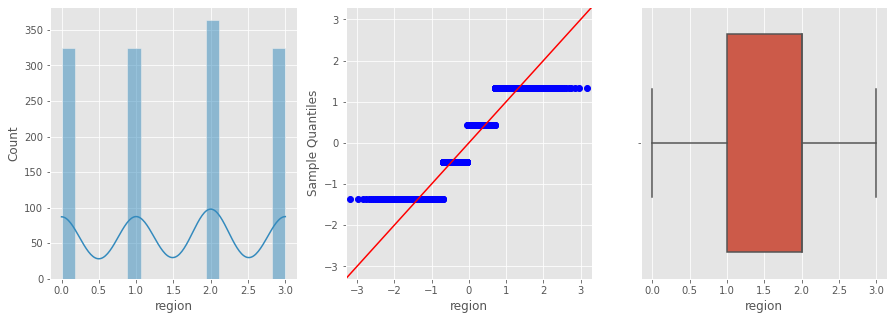

In [11]:
# Check for Normality - Visual Check - Plots not being saved.

for x in featlst:
    fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
    sns.histplot(data=df,x=x,kde=True,ax=ax[0])
    sm.qqplot(df[x],ax=ax[1],line='45',fit=True)
    ax[1].set_xlabel(x)
    sns.boxplot(data=df,x=x,ax=ax[2])
    plt.show()

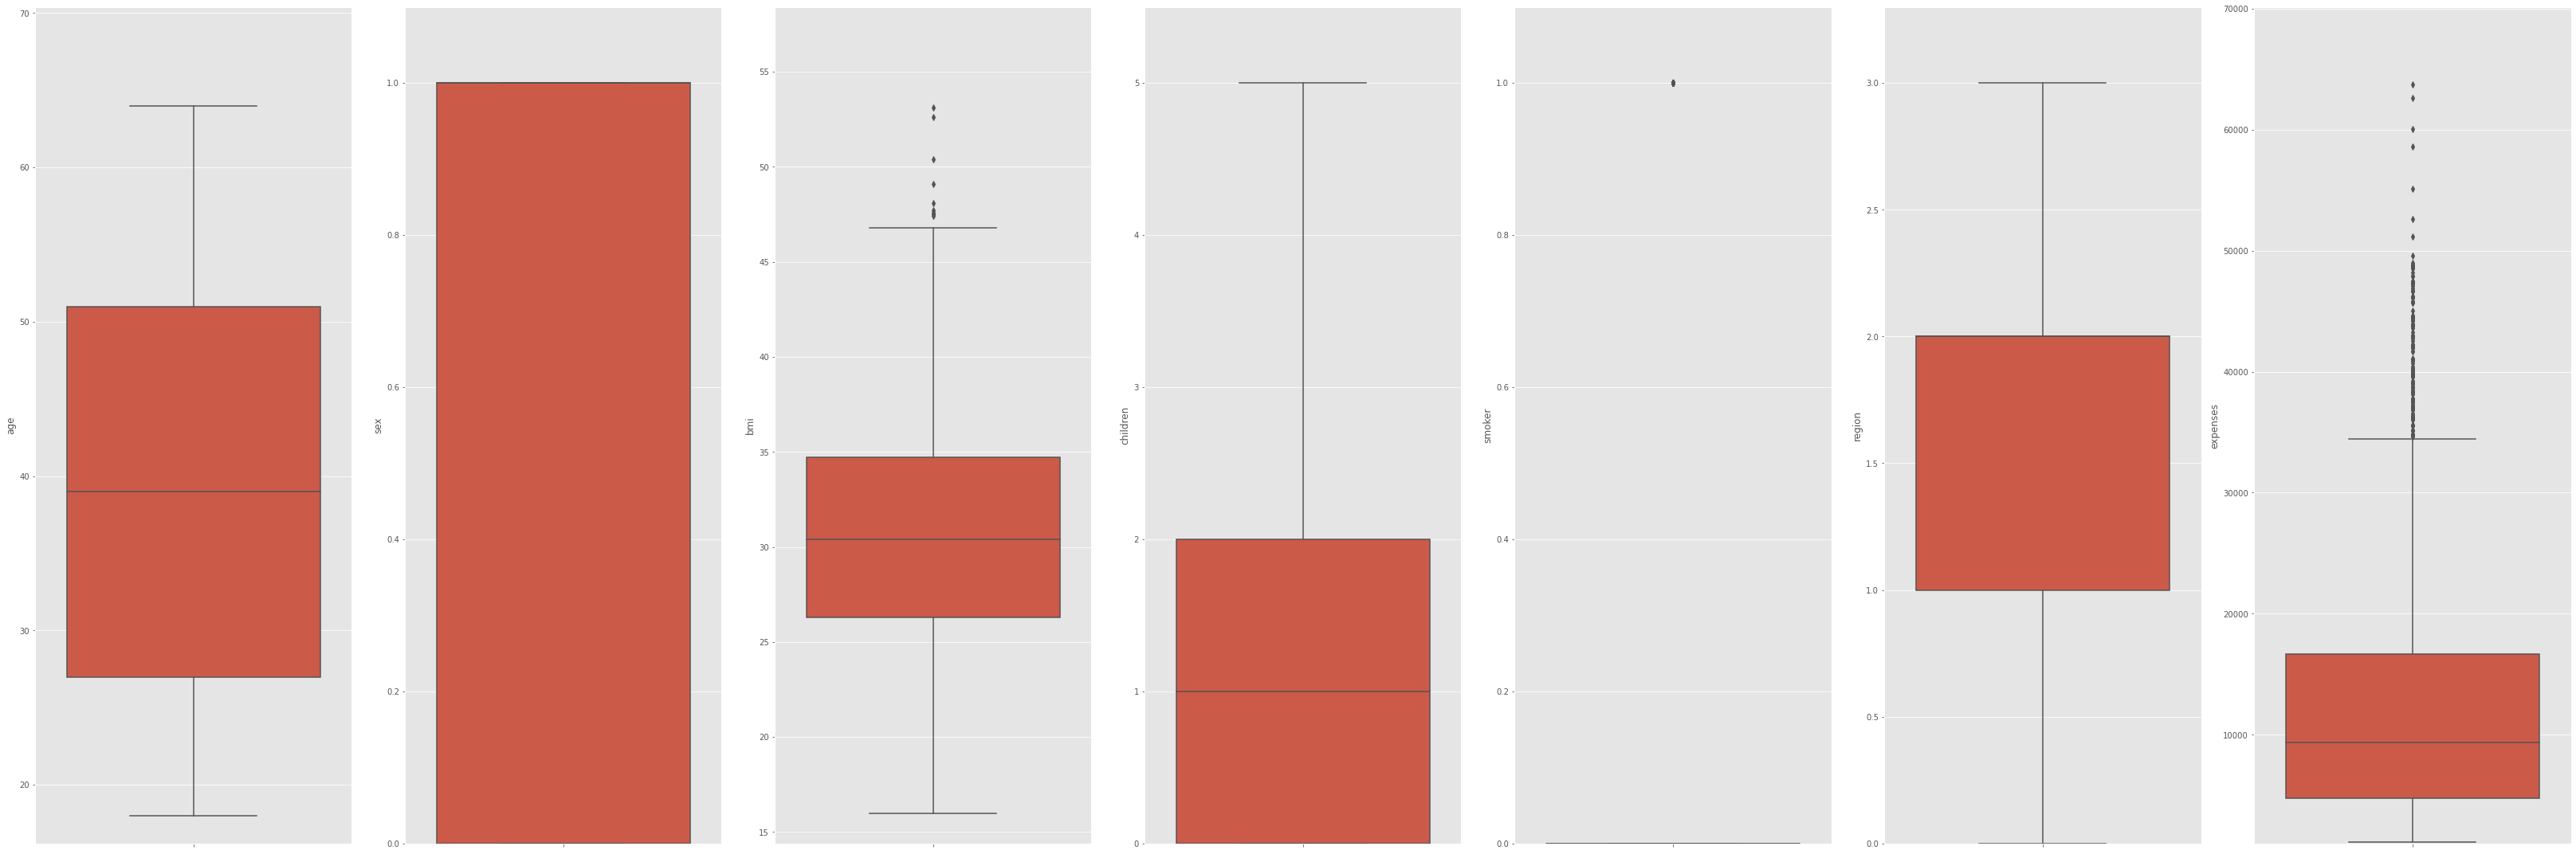

In [12]:
# Box Plot

if len(y_catlst)!= 0:
    NCOLS = 4
    m_rows = int(np.ceil((len(collst)-len(y_catlst))/NCOLS))
    fig, axes = plt.subplots(m_rows, NCOLS, figsize = (15,15))
    axes = axes.flatten()
    for lst in range(0, len(y_catlst), 1):
        temp = 'Fig_0' + str(lst)
        FIG1 = f"{temp}_Boxplot"
        for i in range(0,len(df.columns)-len(y_catlst)):
            sns.boxplot(x=y_catlst[lst], y=df.iloc[:,i], data=df, orient='v', ax=axes[i])
            plt.tight_layout()
            plt.savefig(f"{OUTPATH}{PREFIX}{FIG1}")

if len(y_catlst)== 0:
    FIG1 = r"Fig_01_Boxplot"
    lst = [x for x in collst if x not in y_catlst]
    fig, axes = plt.subplots(1, len(lst), figsize = (45,15))
    axes = axes
    for i, col in enumerate(lst):
        ax = sns.boxplot(y=df[col], ax=axes.flatten()[i])
        axminlt = df[col].min()-0.1*df[col].min()
        axmaxlt = df[col].max()+0.1*df[col].max()
        ax.set_ylim(axminlt, axmaxlt)
        ax.set_ylabel(col)
    plt.tight_layout()
    plt.savefig(f"{OUTPATH}{PREFIX}{FIG1}")

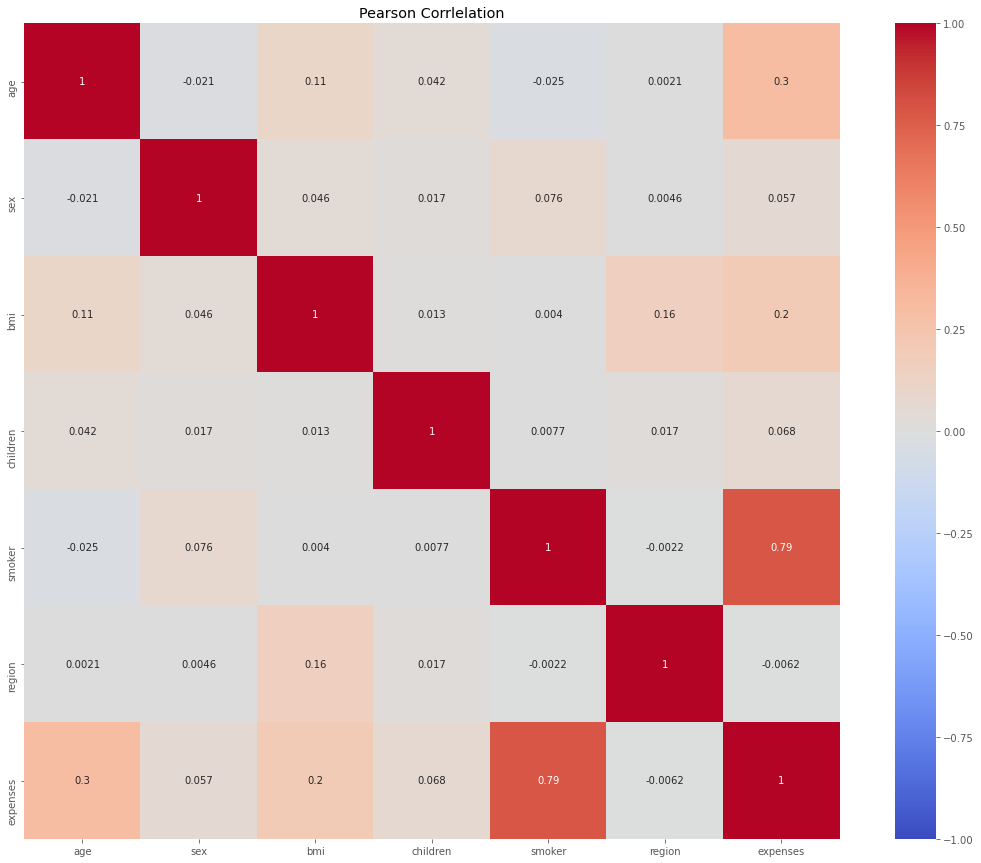

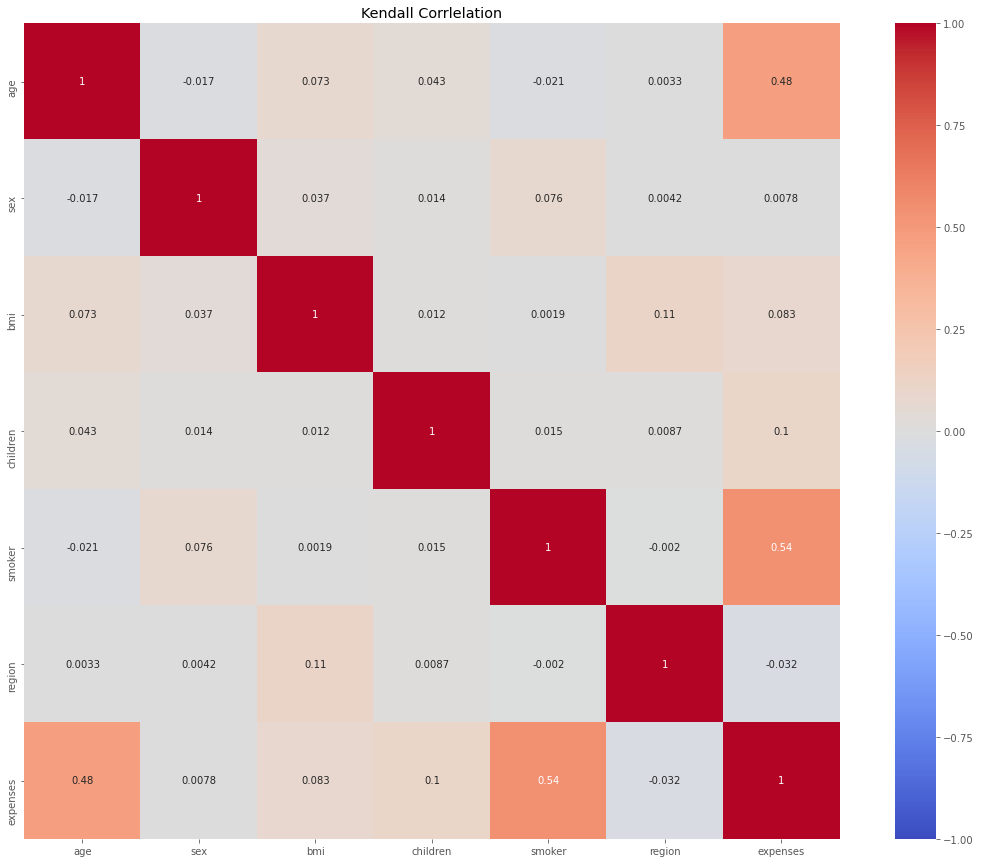

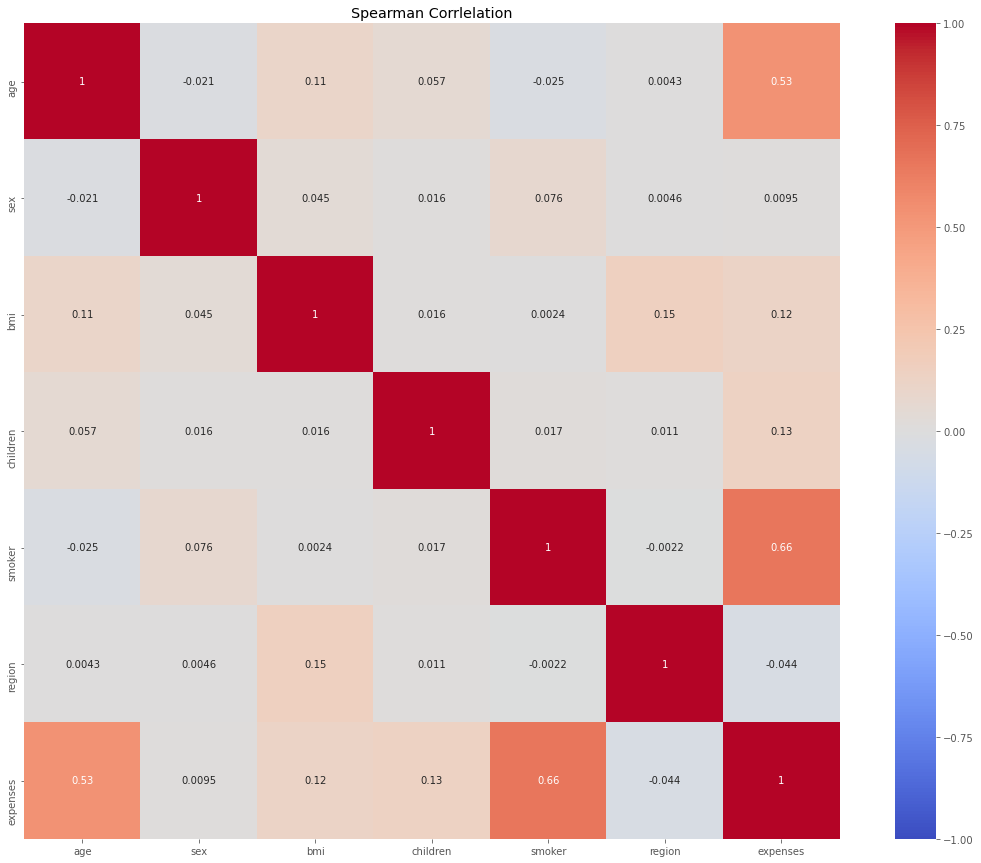

In [13]:
# Linear Correlation Heatmap

cormethod = {0:'pearson', 1:'kendall', 2:'spearman'}
for i in range(0, 3, 1):
    temp = 'linear_cor' + str(i)
    temp = df.corr(method=cormethod[i])
    ftemp = cormethod[i].title()
    FIG2 = r"Fig_02_Corr_"
    mask = np.zeros(temp.shape, dtype=bool)
    mask[np.tril_indices(len(mask))] = False
    plt.subplots(figsize=(20,15))
    plt.title(f"{ftemp} Corrlelation")
    sns.heatmap(temp, annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', square=True, mask=mask)
    plt.savefig(f"{OUTPATH}{PREFIX}{FIG2}{ftemp}")

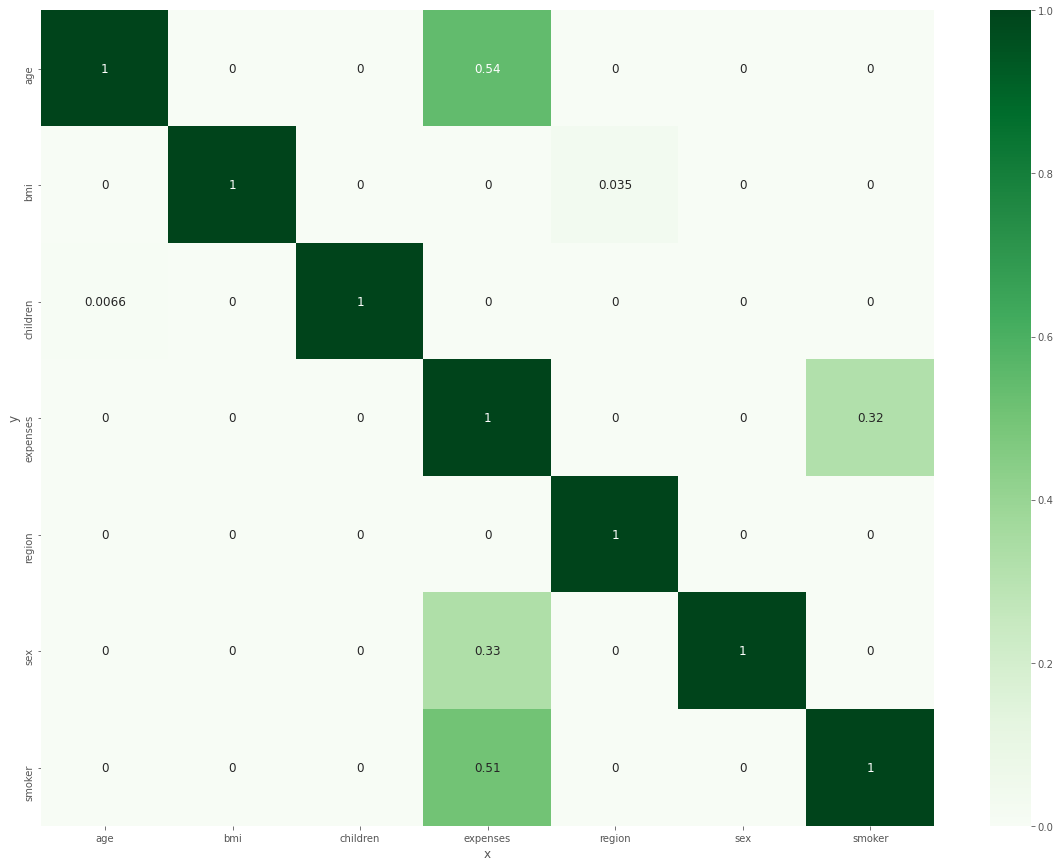

In [14]:
# Non-Linear Correlation Predictive Power Score - Heatmap

FIG3 = r"Fig_03_Predictive_Power_Score"

ppscorr = pps.matrix(df) # Predictive Power Score - PPS
matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y',
                                                        values='ppscore')
plt.subplots(figsize=(20,15))
sns.heatmap(matrix_df, cmap="Greens", annot=True, linewidth=0, annot_kws={"size":12}, fmt='.2g')
plt.savefig(f"{OUTPATH}{PREFIX}{FIG3}")

In [15]:
# Feature Reduction -  Variance Inflation Factor [VIF]

vif_data = pd.DataFrame()
vif_data["Feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

No. of Components Explaining 95% Variance: 5
[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [6] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [6] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >

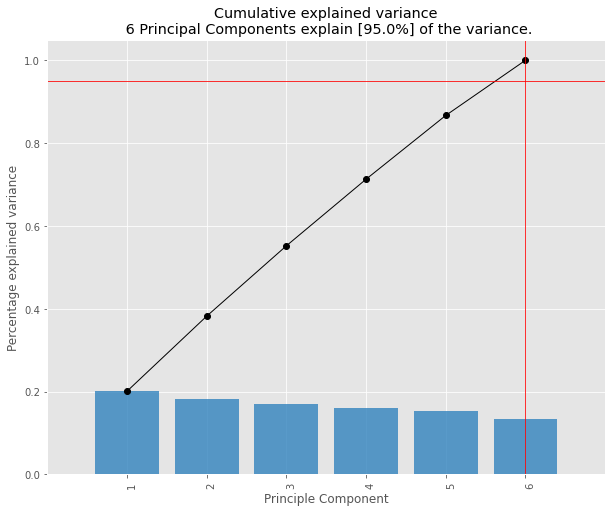

<Figure size 432x288 with 0 Axes>

In [16]:
# Feature Reduction - Principal Component Analysis [PCA]

if n_target == 0:
    X = df.copy()
else:
    X = df.drop(columns=targlst)
    y = df.filter(targlst, axis=1)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Principal Component Analyses

sklpca = SKLPCA(n_components=0.95, svd_solver='full')
sklpca.fit(X_scaled)
X_transform = sklpca.transform(X_scaled)

pricom = pd.DataFrame(sklpca.components_.round(3)) # Principal Components
pricomvar = pd.DataFrame(sklpca.explained_variance_ratio_.round(3))

n_pca_comp = sklpca.n_components_
print("No. of Components Explaining 95% Variance:", n_pca_comp)

# Identifying Top Features of  PCA using pca module

model = pca(n_components=0.95, normalize=True, random_state=RND_STATE)
out = model.fit_transform(X)
pcatopfeat = out['topfeat'].round(3)

# Identifying Top Features of  PCA using pca module

model = pca(n_components=0.95, normalize=True, random_state=RND_STATE)
out = model.fit_transform(X)
pcatopfeat = out['topfeat'].round(3)

FIG4 = r"Fig_04_PCA_Model_Plot"
fig, ax = model.plot()
ax.figure.savefig(f"{OUTPATH}{PREFIX}{FIG4}")


In [17]:
# Feature Importance - Decision Tree Regressor

if n_target != 0:
    X = df.drop(columns=targlst)
    y = df.drop(columns=featlst)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE,
                                                        random_state=RND_STATE)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    MLM_DTR = DecisionTreeRegressor(max_depth=5, random_state=RND_STATE)
    MLM_DTR.fit(X_train, y_train)
    feat_imp = MLM_DTR.feature_importances_.round(3)
    colhead = X.columns.tolist()
    featimp = pd.DataFrame(np.column_stack([colhead, feat_imp]), columns=['Features',
                                                                          'Coefficients'])
    featimp = featimp.sort_values('Coefficients', ascending=False)
else:
    featimptemp = {'Features':[np.nan], 'Coefficients':[np.nan],
                   'Remarks':['Unsupervised Learning']}
    featimp = pd.DataFrame(featimptemp, columns=['Features',
                                                 'Coefficients', 'Remarks'])

Top Features: ['smoker', 'bmi', 'age']


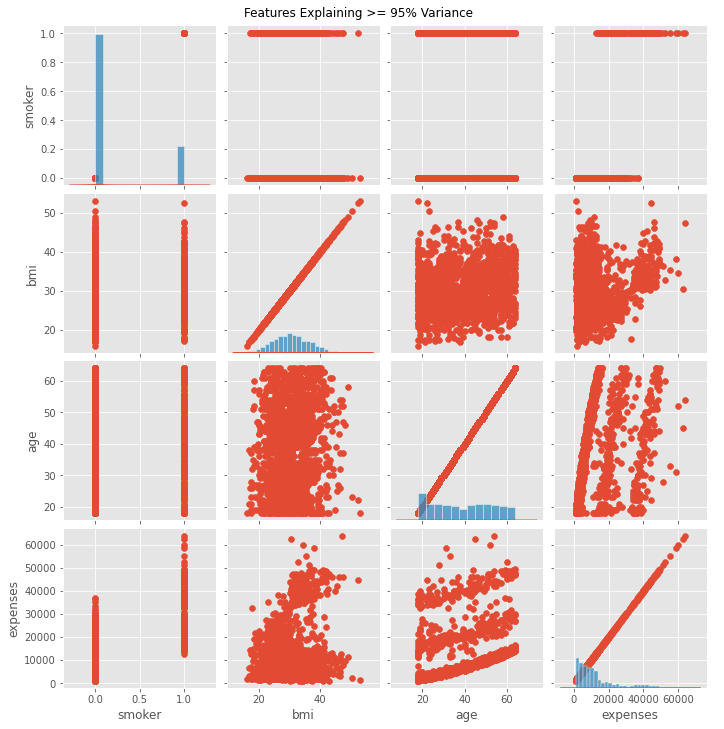

In [18]:
# Scatter Plot of Top Features of Importance from DTR

FIG5 = r"Fig_05_Scatter_Plot"

temp = featimp["Coefficients"].to_numpy()

cumsum = 0
for i in range(0, len(temp), 1):
    cumsum = cumsum + float(temp[i])
    if cumsum >= 0.95:
        break
    else:
        continue

n_crit_feat = i

DTR_featlst = featimp['Features'].to_list()
topfeat = []
for i in range(0, n_crit_feat+1, 1):
    topfeat.append(DTR_featlst[i])
print("Top Features:", topfeat, end='\n')

topfeat.extend(targlst) # Adding target variables to topfeatures

df_scatter = df.filter(topfeat, axis=1)
grid1 = sns.pairplot(df_scatter, hue=None)
grid1.map(plt.scatter)
grid1.map_diag(sns.kdeplot)
grid1.add_legend()
grid1.fig.suptitle("Features Explaining >= 95% Variance", y=1.01)
grid1.savefig(f"{OUTPATH}{PREFIX}{FIG5}")

In [19]:
# EDA Report Out

# Output to Excel

SUMMARY = r"00_Results_Summary.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{SUMMARY}", engine='xlsxwriter', options={'strings_to_numbers': True})
DF_INFO.to_excel(writer, sheet_name='Info')
desc_stat.to_excel(writer, sheet_name='Stats')
vif_data.to_excel(writer, sheet_name='VIF')
pricomvar.to_excel(writer, sheet_name='PCA_VAR')
pricom.to_excel(writer, sheet_name='PCA_Components')
pcatopfeat.to_excel(writer, sheet_name='PCA_Top_Features')
featimp.to_excel(writer, sheet_name='DTR-Features')
writer.save()

In [ ]:
# # High Dimensional Interactive Plot - HD Plot

# import hiplot as hip

# HIDIPLOT = r"01_Parallel_Plot.html"
# parplot = hip.Experiment.from_dataframe(df)
# parplot.to_html(f"{OUTPATH}{PREFIX}{HIDIPLOT}")


In [24]:
!jupyter nbconvert EDA_Feature_Engineering.ipynb --to html --no-input

[NbConvertApp] Converting notebook EDA_Feature_Engineering.ipynb to html
[NbConvertApp] Writing 1191224 bytes to EDA_Feature_Engineering.html
